In [1]:
import os
import gc
from joblib import dump, load
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import xgboost as xgb

# load files

In [2]:
train = pd.read_parquet("../input/train_full_features.parquet")

# define loss and metric

In [3]:
def amex_metric_mod(y_true, y_pred):

    labels     = np.transpose(np.array([y_true, y_pred]))
    labels     = labels[labels[:, 1].argsort()[::-1]]
    weights    = np.where(labels[:,0]==0, 20, 1)
    cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
    top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

    gini = [0,0]
    for i in [1,0]:
        labels         = np.transpose(np.array([y_true, y_pred]))
        labels         = labels[labels[:, i].argsort()[::-1]]
        weight         = np.where(labels[:,0]==0, 20, 1)
        weight_random  = np.cumsum(weight / np.sum(weight))
        total_pos      = np.sum(labels[:, 0] *  weight)
        cum_pos_found  = np.cumsum(labels[:, 0] * weight)
        lorentz        = cum_pos_found / total_pos
        gini[i]        = np.sum((lorentz - weight_random) * weight)

    return 0.5 * (gini[1]/gini[0] + top_four)

# define training config

In [4]:
exclude_features = []

exclude_features += [
    "customer_ID", 
    "target",
    "number_of_observations",
    "year_month",
]
# all_features = [col for col in train.columns if col not in exclude_features]


# selected_feature_idxes = load("selected_feature_idxes.pkl")
# features = [all_features[feature_idx] for feature_idx in selected_feature_idxes]

features = [col for col in train.columns if col not in exclude_features]
target_encoded_features = [col for col in features if "target" in col]
features = [col for col in features if ("D_66" not in col) and ("D_87" not in col) and ("knn" not in col)] + target_encoded_features
# features = [col for col in features if ("D_66" not in col) and ("D_87" not in col)]

cat_features_base = [
    "B_30",
    "B_38",
    "D_114",
    "D_116",
    "D_117",
    "D_120",
    "D_126",
    "D_63",
    "D_64",
    "D_66",
    "D_68"
] 
cat_features = []
for feature in features:
    for cat_feature_base in cat_features_base:
        if cat_feature_base in feature:
            cat_features.append(feature)
            
target = "target"

In [5]:
seed = 42
n_folds = 5

xgb_parms = { 
    "max_depth":4, 
    "learning_rate":0.05, 
    "subsample":0.8,
    "colsample_bytree":0.6, 
    "eval_metric":"logloss",
    "objective":"binary:logistic",
    "tree_method":"gpu_hist",
    "gpu_id":1,
    "predictor":"gpu_predictor",
    "random_state":seed
}

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
seed_everything(seed)

In [6]:
# NEEDED WITH DeviceQuantileDMatrix BELOW
class IterLoadForDMatrix(xgb.core.DataIter):
    def __init__(self, df=None, features=None, target=None, batch_size=256*1024):
        self.features = features
        self.target = target
        self.df = df
        self.it = 0 # set iterator to 0
        self.batch_size = batch_size
        self.batches = int( np.ceil( len(df) / self.batch_size ) )
        super().__init__()

    def reset(self):
        '''Reset the iterator'''
        self.it = 0

    def next(self, input_data):
        '''Yield next batch of data.'''
        if self.it == self.batches:
            return 0 # Return 0 when there's no more batch.
        
        a = self.it * self.batch_size
        b = min( (self.it + 1) * self.batch_size, len(self.df) )
        dt = pd.DataFrame(self.df.iloc[a:b])
        input_data(data=dt[self.features], label=dt[self.target]) #, weight=dt['weight'])
        self.it += 1
        return 1

In [7]:
def training(train):

    importances = []
    
    # create a numpy array to store out of folds predictions
    oof_predictions = np.zeros(len(train))

    kfold = StratifiedKFold(
        n_splits=n_folds, 
        shuffle=True, 
        random_state=seed
    )
    
    for fold,(trn_ind, val_ind) in enumerate(kfold.split(train, train[target])):

        print("#"*100)
        print("Training fold {} with {} features...".format(fold, len(features)))
        
        x_train= train.loc[trn_ind, features]
        y_train= train.loc[trn_ind, target]
        x_val = train.loc[val_ind, features]
        y_val = train.loc[val_ind, target]

        # xgb_train = xgb.DeviceQuantileDMatrix(xy_train, max_bin=256)
        xgb_train = xgb.DMatrix(data=x_train, label=y_train)
        xgb_val = xgb.DMatrix(data=x_val, label=y_val)

        model = xgb.train(
            xgb_parms, 
            dtrain=xgb_train,
            evals=[(xgb_train,"train"),(xgb_val,"valid")],
            num_boost_round=9999,
            early_stopping_rounds=100,
            verbose_eval=100
        ) 
        model.save_model("../ckpt/xgb_{}_{}.xgb".format(fold, seed))

        # importance
        importance = model.get_score(importance_type="weight")
        importances.append(pd.DataFrame({"feature":importance.keys(), "importance_{}".format(fold):importance.values()}))

        # oof
        oof_preds = model.predict(xgb_val)
        score = amex_metric_mod(y_val.values, oof_preds)
        print("fold {} score is {}".format(fold, score))
        
        # add to out of folds array
        oof_predictions[val_ind] = oof_preds

        del x_train, y_train, x_val, y_val, xgb_train, xgb_val, model, importance, oof_preds
        _ = gc.collect()
    
    # compute oof
    score = amex_metric_mod(train[target], oof_predictions)
    print("oof score is {}".format(score))
    
    # create a dataframe to store out of folds predictions
    oof_df = pd.DataFrame({"customer_ID": train["customer_ID"], "target": train[target], "prediction": oof_predictions})
    oof_df.to_parquet("xgb_oof_{}.parquet".format(seed))
    
    return importances, oof_df

In [8]:
importances, oof_df = training(train)

####################################################################################################
Training fold 0 with 2494 features...
[0]	train-logloss:0.66252	valid-logloss:0.66261
[100]	train-logloss:0.23635	valid-logloss:0.23910
[200]	train-logloss:0.22194	valid-logloss:0.22691
[300]	train-logloss:0.21591	valid-logloss:0.22319
[400]	train-logloss:0.21173	valid-logloss:0.22124
[500]	train-logloss:0.20842	valid-logloss:0.22029
[600]	train-logloss:0.20552	valid-logloss:0.21958
[700]	train-logloss:0.20297	valid-logloss:0.21908
[800]	train-logloss:0.20054	valid-logloss:0.21873
[900]	train-logloss:0.19825	valid-logloss:0.21845
[1000]	train-logloss:0.19602	valid-logloss:0.21824
[1100]	train-logloss:0.19389	valid-logloss:0.21810
[1200]	train-logloss:0.19193	valid-logloss:0.21796
[1300]	train-logloss:0.18994	valid-logloss:0.21792
[1400]	train-logloss:0.18804	valid-logloss:0.21785
[1500]	train-logloss:0.18610	valid-logloss:0.21787
[1508]	train-logloss:0.18595	valid-logloss:0.21787
fold 0

# feature importance

In [9]:
importance = importances[0].copy()
for k in range(1, n_folds): 
    importance = importance.merge(importances[k], on="feature", how="left")
    
importance["importance"] = importance.iloc[:,1:].mean(axis=1)
importance = importance.sort_values("importance",ascending=False)

# importance.to_csv("xgb_feature_importance.csv",index=False)

In [10]:
importance

,feature,importance_0,importance_1,importance_2,importance_3,importance_4,importance
21,P_2_last,229.0,233.0,237.0,229.0,237.0,233.0
26,D_39_last,177.0,193.0,179.0,193.0,176.0,183.6
79,B_4_last,154.0,132.0,135.0,132.0,130.0,136.6
57,B_3_last,108.0,119.0,111.0,119.0,123.0,116.0
17,P_2_mean,91.0,96.0,86.0,100.0,98.0,94.2
...,...,...,...,...,...,...,...
843,B_33_count_unique,1.0,NaN,1.0,NaN,NaN,1.0
182,S_6_last,1.0,NaN,NaN,NaN,NaN,1.0
356,D_73_min,1.0,1.0,NaN,1.0,NaN,1.0
1234,D_86_quantile_25,1.0,NaN,NaN,1.0,NaN,1.0


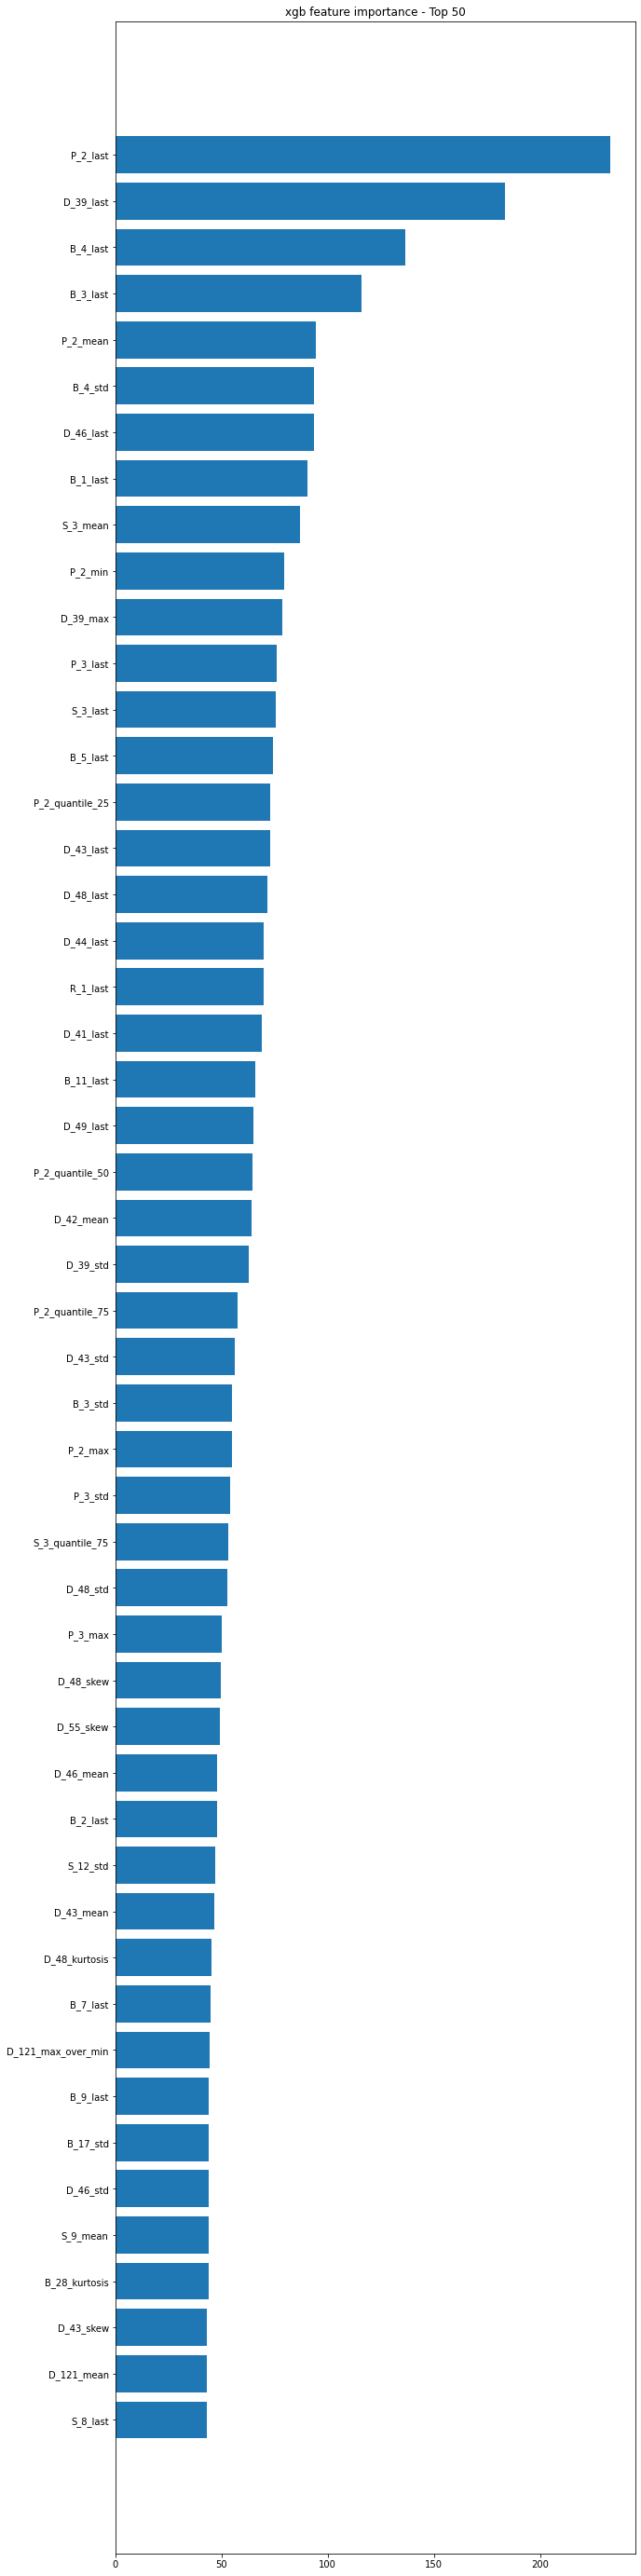

In [11]:
n_features = 50

plt.figure(figsize=(10, n_features))
plt.barh(np.arange(n_features, 0, -1), importance.importance.values[:n_features])
plt.yticks(np.arange(n_features,0,-1), importance.feature.values[:n_features])
plt.title("xgb feature importance - Top {}".format(n_features))
plt.show()

In [ ]:
importance.head(50)

In [ ]:
P_2 = [col for col in importance["feature"] if "target" in col]

In [ ]:
importance.loc[importance["feature"].isin(P_2)]

In [ ]:
B_39

In [ ]:
def permutation(train, features):
    
    permutation_importances = {}
    
    for feature in tqdm(features):
        
        oof_predictions = np.zeros(len(train))
        
        kfold = StratifiedKFold(
            n_splits=n_folds, 
            shuffle=True, 
            random_state=seed
        )
    
        for fold,(trn_ind, val_ind) in enumerate(kfold.split(train, train[target])):

            x_val = train.loc[val_ind, features]
            x_val[feature] = np.random.RandomState(seed=42).permutation(x_val[feature])
            y_val = train.loc[val_ind, target]

            xgb_val = xgb.DMatrix(data=x_val, label=y_val)
            
            model = xgb.Booster()
            model.load_model("../ckpt/xgb_{}_{}.xgb".format(fold, seed))

            # oof
            oof_preds = model.predict(xgb_val)
            oof_predictions[val_ind] = oof_preds

            del x_val, y_val, xgb_val, model, oof_preds
            _ = gc.collect()

        # compute oof
        score = amex_metric_mod(train[target], oof_predictions)
        permutation_importances[feature] = score
    
        dump(permutation_importances, "permutation_importances.pkl")
    
    return permutation_importances

In [ ]:
# permutation_importances = permutation(train, features)